In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped, PURankingLoss
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load data

In [2]:
DATA_DIR = os.path.join("data", "UCI HAR Dataset")

In [3]:
X_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "X_train.txt"),
    delim_whitespace=True,
    header=None
)
X_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "X_test.txt"),
    delim_whitespace=True,
    header=None
)

y_train = pd.read_csv(
    os.path.join(DATA_DIR, "train", "y_train.txt"),
    header=None
)[0]
y_test = pd.read_csv(
    os.path.join(DATA_DIR, "test", "y_test.txt"),
    header=None
)[0]

/tmp/ipykernel_471/1776149928.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(
/tmp/ipykernel_471/1776149928.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(


In [4]:
pd.set_option('display.max_columns', None)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,0.963396,-0.140840,0.115375,-0.985250,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.124660,0.977436,-0.123213,0.056483,-0.375426,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,-0.591773,0.592469,-0.745449,0.720862,-0.712372,0.711300,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.077996,0.005001,-0.067831,-0.993519,-0.988360,-0.993575,-0.994488,-0.986207,-0.992818,-0.985180,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.999820,-0.999878,-0.994364,-0.986025,-0.989234,-0.819949,-0.793046,-0.888853,1.000000,-0.220747,0.636831,0.387644,0.241401,-0.052253,0.264177,0.373439,0.341778,-0.569791,0.265399,-0.477875,-0.385300,0.033644,-0.126511,-0.006101,-0.031365,0.107725,-0.985310,-0.976623,-0.992205,-0.984586,-0.976353,-0.992362,-0.867044,-0.933786,-0.747566,0.847308,0.914895,0.830841,-0.967184,-0.999578,-0.999354,-0.999763,-0.983438,-0.978614,-0.992966,0.082632,0.202268,-0.168757,0.096323,-0.274985,0.498644,-0.220317,1.000000,-0.972971,0.316655,0.375726,0.723399,-0.771112,0.690213,-0.331831,0.709584,0.134873,0.301099,-0.099167,-0.055517,-0.061986,-0.992111,-0.992519,-0.992055,-0.992165,-0.994942,-0.992619,-0.990156,-0.986743,-0.992042,0.994429,0.991756,0.989352,-0.994453,-0.999938,-0.999954,-0.999923,-0.992300,-0.996939,-0.992243,-0.589851,-0.688459,-0.572107,0.292376,-0.361998,0.405543,-0.039007,0.989284,-0.414560,0.391603,0.282251,0.927270,-0

In [5]:
activity_labels_df = pd.read_csv("data/UCI HAR Dataset/activity_labels.txt", sep='\s+', header=None, names=["id", "label"])
print(activity_labels_df)
labels = activity_labels_df["label"].to_list()

   id               label
0   1             WALKING
1   2    WALKING_UPSTAIRS
2   3  WALKING_DOWNSTAIRS
3   4             SITTING
4   5            STANDING
5   6              LAYING


In [6]:
y_train_np = y_train.to_numpy() - 1
y_test_np = y_test.to_numpy() - 1

In [7]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()


In [8]:
X_tr_tensor   = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_tr_tensor   = torch.tensor(y_train.values, dtype=torch.long) - 1
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long) - 1


In [9]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [10]:
batch_size = 64

tr_dataset   = TensorDataset(X_tr_tensor, y_tr_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader   = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True) # train 
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # test

# Multiclass Learning

## Try RF as baseline

In [15]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_np, y_train_np)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = clf.predict(X_test_np)

In [17]:
print(classification_report(y_test_np, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8887    0.9657    0.9256       496
           1     0.8845    0.8938    0.8891       471
           2     0.9704    0.8595    0.9116       420
           3     0.9112    0.8982    0.9046       491
           4     0.9072    0.9192    0.9132       532
           5     1.0000    1.0000    1.0000       537

    accuracy                         0.9257      2947
   macro avg     0.9270    0.9227    0.9240      2947
weighted avg     0.9270    0.9257    0.9256      2947



## CNN

In [ ]:
from baseline import Conv_Net, train, LSTMNet

In [21]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_train.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 128
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 6


In [22]:
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
print(model)

NameError: name 'Conv_Net' is not defined

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1
model = model.to(device)

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
model = train(model, train_loader, test_loader, in_channel, seq_length, n_hidden, n_output, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:01<00:00, 89.46it/s] 


Epoch [1/15], tr_loss: 0.99697 tr_acc: 0.65846 test_loss: 0.57657, test_acc: 0.85986


100%|██████████| 115/115 [00:01<00:00, 105.62it/s]


Epoch [2/15], tr_loss: 0.39188 tr_acc: 0.87935 test_loss: 0.34782, test_acc: 0.87106


100%|██████████| 115/115 [00:01<00:00, 106.34it/s]


Epoch [3/15], tr_loss: 0.23968 tr_acc: 0.92451 test_loss: 0.22992, test_acc: 0.92806


100%|██████████| 115/115 [00:01<00:00, 105.00it/s]


Epoch [4/15], tr_loss: 0.19042 tr_acc: 0.93240 test_loss: 0.20425, test_acc: 0.93315


100%|██████████| 115/115 [00:01<00:00, 103.07it/s]


Epoch [5/15], tr_loss: 0.15205 tr_acc: 0.94627 test_loss: 0.21060, test_acc: 0.91313


100%|██████████| 115/115 [00:01<00:00, 99.18it/s] 


Epoch [6/15], tr_loss: 0.12871 tr_acc: 0.95362 test_loss: 0.15832, test_acc: 0.94537


100%|██████████| 115/115 [00:01<00:00, 100.26it/s]


Epoch [7/15], tr_loss: 0.11094 tr_acc: 0.96015 test_loss: 0.16002, test_acc: 0.93553


100%|██████████| 115/115 [00:01<00:00, 99.44it/s]


Epoch [8/15], tr_loss: 0.09825 tr_acc: 0.96613 test_loss: 0.15889, test_acc: 0.93281


100%|██████████| 115/115 [00:01<00:00, 97.38it/s]


Epoch [9/15], tr_loss: 0.08928 tr_acc: 0.97008 test_loss: 0.13489, test_acc: 0.94842


100%|██████████| 115/115 [00:01<00:00, 95.85it/s]


Epoch [10/15], tr_loss: 0.08486 tr_acc: 0.97225 test_loss: 0.14347, test_acc: 0.93926


100%|██████████| 115/115 [00:01<00:00, 102.96it/s]


Epoch [11/15], tr_loss: 0.07326 tr_acc: 0.97334 test_loss: 0.12550, test_acc: 0.95148


100%|██████████| 115/115 [00:01<00:00, 102.05it/s]


Epoch [12/15], tr_loss: 0.07212 tr_acc: 0.97511 test_loss: 0.12708, test_acc: 0.95046


100%|██████████| 115/115 [00:01<00:00, 105.31it/s]


Epoch [13/15], tr_loss: 0.06864 tr_acc: 0.97701 test_loss: 0.12831, test_acc: 0.95012


100%|██████████| 115/115 [00:01<00:00, 105.41it/s]


Epoch [14/15], tr_loss: 0.06418 tr_acc: 0.97688 test_loss: 0.11774, test_acc: 0.95385


100%|██████████| 115/115 [00:01<00:00, 102.95it/s]


Epoch [15/15], tr_loss: 0.06029 tr_acc: 0.97987 test_loss: 0.12552, test_acc: 0.95385


In [ ]:
out_test = model(X_test_tensor.to(device))
preds_test = torch.max(out_test, 1)[1]

In [ ]:
preds_test.cpu().detach().numpy()

array([4, 4, 4, ..., 1, 1, 1])

In [ ]:
print(classification_report(y_test_np, preds_test.cpu().detach().numpy(), digits=4))

              precision    recall  f1-score   support

           0     0.9370    0.9899    0.9627       496
           1     0.9384    0.9384    0.9384       471
           2     0.9898    0.9286    0.9582       420
           3     0.9429    0.9084    0.9253       491
           4     0.9283    0.9492    0.9387       532
           5     0.9926    1.0000    0.9963       537

    accuracy                         0.9539      2947
   macro avg     0.9549    0.9524    0.9533      2947
weighted avg     0.9543    0.9539    0.9537      2947



## LSTM with dropout + batchnorm 

In [ ]:
from baseline import Conv_Net, train, LSTMNet
model_lstm = LSTMNet(in_channel, hidden_dim=64, n_output=6, num_layers=1)
model_lstm.to(device)

LSTMNet(
  (lstm): LSTM(1, 64, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)

In [ ]:
model_lstm = train(model_lstm, train_loader, test_loader, lr, 20, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:01<00:00, 73.05it/s]


Epoch [1/20], tr_loss: 1.58529 tr_acc: 0.34168 test_loss: 1.48732, test_acc: 0.41771


100%|██████████| 115/115 [00:01<00:00, 100.83it/s]


Epoch [2/20], tr_loss: 1.40076 tr_acc: 0.43050 test_loss: 1.39601, test_acc: 0.46115


100%|██████████| 115/115 [00:01<00:00, 106.76it/s]


Epoch [3/20], tr_loss: 1.32448 tr_acc: 0.47429 test_loss: 1.29549, test_acc: 0.52664


100%|██████████| 115/115 [00:01<00:00, 106.93it/s]


Epoch [4/20], tr_loss: 1.07145 tr_acc: 0.60623 test_loss: 0.96570, test_acc: 0.63047


100%|██████████| 115/115 [00:01<00:00, 102.88it/s]


Epoch [5/20], tr_loss: 0.87593 tr_acc: 0.65805 test_loss: 0.87754, test_acc: 0.65864


100%|██████████| 115/115 [00:01<00:00, 105.64it/s]


Epoch [6/20], tr_loss: 0.81576 tr_acc: 0.67750 test_loss: 0.88833, test_acc: 0.64031


100%|██████████| 115/115 [00:01<00:00, 100.41it/s]


Epoch [7/20], tr_loss: 0.77487 tr_acc: 0.70035 test_loss: 0.91527, test_acc: 0.60468


100%|██████████| 115/115 [00:01<00:00, 98.51it/s] 


Epoch [8/20], tr_loss: 0.73771 tr_acc: 0.71844 test_loss: 0.76613, test_acc: 0.66271


100%|██████████| 115/115 [00:01<00:00, 100.70it/s]


Epoch [9/20], tr_loss: 0.68386 tr_acc: 0.74905 test_loss: 0.71852, test_acc: 0.69969


100%|██████████| 115/115 [00:01<00:00, 102.65it/s]


Epoch [10/20], tr_loss: 0.65311 tr_acc: 0.75653 test_loss: 0.74048, test_acc: 0.70207


100%|██████████| 115/115 [00:01<00:00, 95.38it/s]


Epoch [11/20], tr_loss: 0.60620 tr_acc: 0.77816 test_loss: 0.69134, test_acc: 0.71395


100%|██████████| 115/115 [00:01<00:00, 98.03it/s]


Epoch [12/20], tr_loss: 0.56436 tr_acc: 0.79869 test_loss: 0.68331, test_acc: 0.72718


100%|██████████| 115/115 [00:01<00:00, 102.78it/s]


Epoch [13/20], tr_loss: 0.54496 tr_acc: 0.80291 test_loss: 0.63584, test_acc: 0.76077


100%|██████████| 115/115 [00:01<00:00, 103.01it/s]


Epoch [14/20], tr_loss: 0.51834 tr_acc: 0.80985 test_loss: 0.65728, test_acc: 0.74347


100%|██████████| 115/115 [00:01<00:00, 104.80it/s]


Epoch [15/20], tr_loss: 0.48812 tr_acc: 0.82073 test_loss: 0.60911, test_acc: 0.75942


100%|██████████| 115/115 [00:01<00:00, 106.52it/s]


Epoch [16/20], tr_loss: 0.47187 tr_acc: 0.82848 test_loss: 0.58269, test_acc: 0.78012


100%|██████████| 115/115 [00:01<00:00, 107.88it/s]


Epoch [17/20], tr_loss: 0.46657 tr_acc: 0.82386 test_loss: 0.59281, test_acc: 0.76247


100%|██████████| 115/115 [00:01<00:00, 107.79it/s]


Epoch [18/20], tr_loss: 0.45087 tr_acc: 0.83107 test_loss: 0.63989, test_acc: 0.76552


100%|██████████| 115/115 [00:01<00:00, 110.04it/s]


Epoch [19/20], tr_loss: 0.44592 tr_acc: 0.83025 test_loss: 0.57175, test_acc: 0.78317


100%|██████████| 115/115 [00:01<00:00, 106.82it/s]


Epoch [20/20], tr_loss: 0.43677 tr_acc: 0.83107 test_loss: 0.56708, test_acc: 0.78419


In [ ]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)  # permute once here
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_np))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

all_preds = []
model_lstm.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_lstm(batch_X)
        preds = torch.max(outputs, 1)[1]
        all_preds.append(preds.cpu())

# Concatenate all predictions
all_preds = torch.cat(all_preds).numpy()

print(classification_report(y_test_np, all_preds, digits=4))
print(confusion_matrix(y_test_np, all_preds))


              precision    recall  f1-score   support

           0     0.6898    0.6815    0.6856       496
           1     0.6727    0.8684    0.7581       471
           2     0.7651    0.5738    0.6558       420
           3     0.7650    0.8289    0.7957       491
           4     0.8256    0.7650    0.7941       532
           5     1.0000    0.9479    0.9732       537

    accuracy                         0.7842      2947
   macro avg     0.7864    0.7776    0.7771      2947
weighted avg     0.7914    0.7842    0.7833      2947



## InceptionTime

In [ ]:
from tsai.all import *

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_np, y_test_np])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,
                   metrics=accuracy, cbs=ShowGraph())


epoch,train_loss,valid_loss,accuracy,time
0,0.902639,1.313098,0.390567,00:16
1,0.370857,3.085572,0.325755,00:16
2,0.200351,3.122836,0.411266,00:15
3,0.131067,2.709426,0.350865,00:16
4,0.083907,2.386305,0.744147,00:16
5,0.077825,5.750452,0.340685,00:16
6,0.048378,0.404766,0.855446,00:16
7,0.034838,0.176746,0.935528,00:18
8,0.019440,0.113067,0.957923,00:17
9,0.014881,0.104750,0.959620,00:17


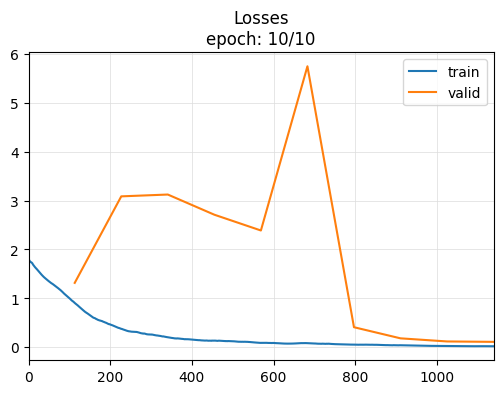

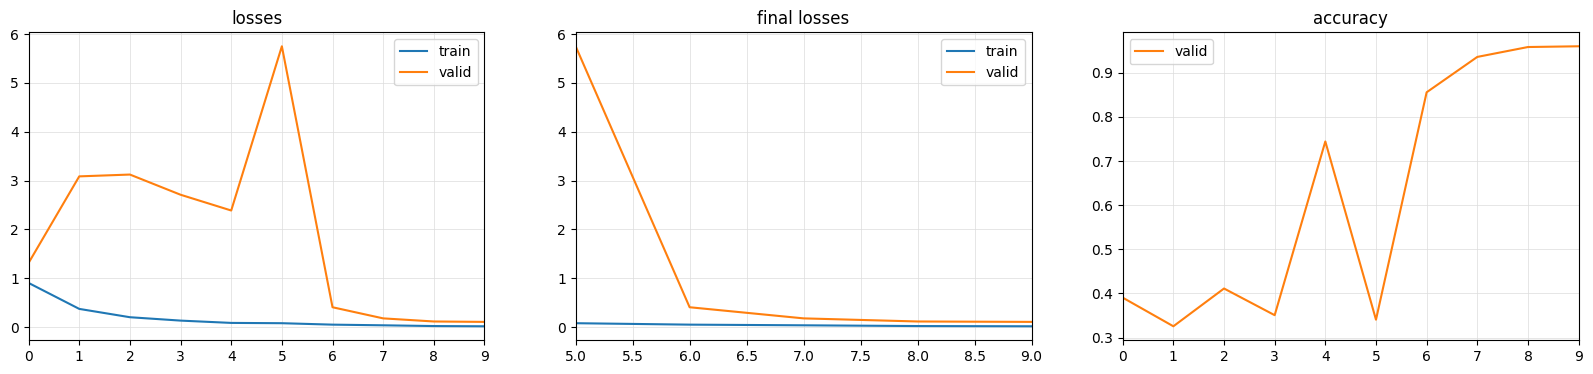

In [ ]:
clf.fit_one_cycle(10, 1e-3)

In [ ]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
probas, target, preds = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]])

In [ ]:
print(classification_report(target, preds.astype(int), digits=4))

              precision    recall  f1-score   support

           0     0.9421    0.9839    0.9625       496
           1     0.9651    0.9384    0.9516       471
           2     0.9830    0.9643    0.9736       420
           3     0.9417    0.9206    0.9310       491
           4     0.9300    0.9492    0.9395       532
           5     1.0000    0.9981    0.9991       537

    accuracy                         0.9596      2947
   macro avg     0.9603    0.9591    0.9595      2947
weighted avg     0.9599    0.9596    0.9596      2947



In [ ]:
print(confusion_matrix(target, preds.astype(int)))

[[488   3   5   0   0   0]
 [ 26 442   2   0   1   0]
 [  4  11 405   0   0   0]
 [  0   2   0 452  37   0]
 [  0   0   0  27 505   0]
 [  0   0   0   1   0 536]]


## Mamba Classifier

In [ ]:
from baseline import MambaClassifier, train

criterion = nn.CrossEntropyLoss()
model_mamba = MambaClassifier(in_channel, hidden_dim=64, num_classes=6, num_layers=2, dropout=0.5)
model_mamba = model_mamba.to(device)
print(model_mamba)

MambaClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (blocks): Sequential(
    (0): MambaBlock(
      (mamba): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): MambaBlock(
      (mamba): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Lin

In [ ]:
model_mamba = train(model_mamba, criterion, train_loader, test_loader, 0.01, 20, device)

100%|██████████| 115/115 [00:06<00:00, 19.10it/s]


Epoch [1/20], tr_loss: 1.15372 tr_acc: 0.39268 test_loss: 1.00416, test_acc: 0.55243


100%|██████████| 115/115 [00:05<00:00, 20.08it/s]


Epoch [2/20], tr_loss: 0.71050 tr_acc: 0.66934 test_loss: 0.69962, test_acc: 0.71530


100%|██████████| 115/115 [00:05<00:00, 20.07it/s]


Epoch [3/20], tr_loss: 0.46539 tr_acc: 0.80060 test_loss: 0.55333, test_acc: 0.81099


100%|██████████| 115/115 [00:05<00:00, 19.99it/s]


Epoch [4/20], tr_loss: 0.33785 tr_acc: 0.86711 test_loss: 0.48227, test_acc: 0.82083


100%|██████████| 115/115 [00:05<00:00, 19.92it/s]


Epoch [5/20], tr_loss: 0.31050 tr_acc: 0.87935 test_loss: 0.63111, test_acc: 0.80998


100%|██████████| 115/115 [00:05<00:00, 19.91it/s]


Epoch [6/20], tr_loss: 0.28043 tr_acc: 0.89404 test_loss: 0.44986, test_acc: 0.85375


100%|██████████| 115/115 [00:05<00:00, 19.81it/s]


Epoch [7/20], tr_loss: 0.23879 tr_acc: 0.90846 test_loss: 0.49441, test_acc: 0.83441


100%|██████████| 115/115 [00:05<00:00, 19.79it/s]


Epoch [8/20], tr_loss: 0.23216 tr_acc: 0.91132 test_loss: 0.52718, test_acc: 0.83068


100%|██████████| 115/115 [00:05<00:00, 19.76it/s]


Epoch [9/20], tr_loss: 0.20908 tr_acc: 0.91989 test_loss: 0.51817, test_acc: 0.85545


100%|██████████| 115/115 [00:05<00:00, 19.81it/s]


Epoch [10/20], tr_loss: 0.21672 tr_acc: 0.91703 test_loss: 0.42212, test_acc: 0.86597


100%|██████████| 115/115 [00:05<00:00, 19.77it/s]


Epoch [11/20], tr_loss: 0.22384 tr_acc: 0.91322 test_loss: 0.44911, test_acc: 0.87004


100%|██████████| 115/115 [00:05<00:00, 19.76it/s]


Epoch [12/20], tr_loss: 0.20690 tr_acc: 0.91812 test_loss: 0.45662, test_acc: 0.87309


100%|██████████| 115/115 [00:05<00:00, 19.57it/s]


Epoch [13/20], tr_loss: 0.18553 tr_acc: 0.92777 test_loss: 0.39605, test_acc: 0.87173


100%|██████████| 115/115 [00:05<00:00, 19.69it/s]


Epoch [14/20], tr_loss: 0.17775 tr_acc: 0.93050 test_loss: 0.54628, test_acc: 0.85748


100%|██████████| 115/115 [00:05<00:00, 19.54it/s]


Epoch [15/20], tr_loss: 0.17509 tr_acc: 0.92913 test_loss: 0.38037, test_acc: 0.88293


100%|██████████| 115/115 [00:05<00:00, 19.61it/s]


Epoch [16/20], tr_loss: 0.17791 tr_acc: 0.92941 test_loss: 0.51227, test_acc: 0.85884


100%|██████████| 115/115 [00:05<00:00, 19.60it/s]


Epoch [17/20], tr_loss: 0.18362 tr_acc: 0.92533 test_loss: 0.39091, test_acc: 0.86868


100%|██████████| 115/115 [00:05<00:00, 19.60it/s]


Epoch [18/20], tr_loss: 0.19274 tr_acc: 0.92519 test_loss: 0.35386, test_acc: 0.87954


100%|██████████| 115/115 [00:05<00:00, 19.59it/s]


Epoch [19/20], tr_loss: 0.15673 tr_acc: 0.93716 test_loss: 0.42909, test_acc: 0.87581


100%|██████████| 115/115 [00:05<00:00, 19.56it/s]


Epoch [20/20], tr_loss: 0.16105 tr_acc: 0.93267 test_loss: 0.28833, test_acc: 0.90668


In [ ]:
#out_test = model_mamba(X_test_tensor.permute(0, 2, 1).to(device))
test_dataset = TensorDataset(X_test_tensor.permute(0, 2, 1), torch.from_numpy(y_test_np))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

all_preds = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.max(outputs, 1)[1]
        all_preds.append(preds.cpu())

# Concatenate all predictions
all_preds = torch.cat(all_preds).numpy()

print(classification_report(y_test_np, all_preds, digits=4))
print(confusion_matrix(y_test_np, all_preds))

              precision    recall  f1-score   support

           0     0.8790    0.9375    0.9073       496
           1     0.9081    0.9023    0.9052       471
           2     0.9386    0.8738    0.9051       420
           3     0.8506    0.8697    0.8600       491
           4     0.8748    0.8534    0.8639       532
           5     0.9926    0.9944    0.9935       537

    accuracy                         0.9067      2947
   macro avg     0.9073    0.9052    0.9058      2947
weighted avg     0.9073    0.9067    0.9067      2947

[[465  10  21   0   0   0]
 [ 43 425   3   0   0   0]
 [ 21  31 367   0   1   0]
 [  0   1   0 427  62   1]
 [  0   0   0  75 454   3]
 [  0   1   0   0   2 534]]


# PU-learning

In [11]:
positive_class = 2
# y_train_pu = (y_train_np == positive_class).astype(int)
# y_test_pu  = (y_test_np  == positive_class).astype(int)

# y_train_pu = np.where(y_train_np == positive_class, 1, -1)
# y_test_pu = np.where(y_test_np == positive_class, 1, -1)
# y_train_pu[y_train_pu == 1].sum()

positive_class = 2
# y_train_pu = (y_train_np == positive_class).astype(int)
# y_test_pu  = (y_test_np  == positive_class).astype(int)
# print(y_train_pu[y_train_pu == 1].sum())
# # Mark half of the positive labels as unlabeled
# pos_idx = np.where(y_train_pu == 1)[0]
# np.random.seed(0)
# unmark_pos = np.random.choice(pos_idx, size=len(pos_idx)//2, replace=False)

# y_train_pu[unmark_pos] = 0
# print(y_train_pu[y_train_pu == 1].sum())


y_train_pu = np.where(y_train_np == positive_class, 1, -1)
y_test_pu = np.where(y_test_np == positive_class, 1, -1)
print(y_train_pu[y_train_pu == 1].sum())

pos_idx = np.where(y_train_pu == 1)[0]
np.random.seed(0)
unmark_pos = np.random.choice(pos_idx, size=len(pos_idx)//2, replace=False)
y_train_pu[unmark_pos] = -1
print(y_train_pu[y_train_pu == 1].sum())




986
493


In [12]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)
X_test_tensor = X_test_tensor.view(X_test_tensor.shape[0], 1, -1)
print(X_tr_tensor.shape, X_test_tensor.shape)

torch.Size([7352, 1, 561]) torch.Size([2947, 1, 561])


In [13]:
batch_size = 64

In [14]:
y_tr_tensor_pu   = torch.tensor(y_train_pu, dtype=torch.long)
y_test_tensor_pu = torch.tensor(y_test_pu, dtype=torch.long)

tr_dataset_pu   = TensorDataset(X_tr_tensor, y_tr_tensor_pu)
test_dataset_pu = TensorDataset(X_test_tensor, y_test_tensor_pu)

train_loader_pu = DataLoader(tr_dataset_pu, batch_size=batch_size, shuffle=False)
test_loader_pu  = DataLoader(test_dataset_pu, batch_size=batch_size, shuffle=False)


In [15]:
# positive_prior = np.where(y_train_np == positive_class, 1, 0).mean()
# positive_prior

positive_prior = torch.tensor(
    np.where(y_train_np == positive_class, 1, 0).mean(),
    dtype=torch.float32
)
# positive_prior = torch.tensor((y_train_pu).mean(),
#                               dtype=torch.float32)

positive_prior = torch.tensor(
    np.where(y_train_pu == 1, 1, 0).mean(),
    dtype=torch.float32
)
positive_prior

tensor(0.0671)

## CNN

In [17]:
in_channel = X_tr_tensor.shape[1]
seq_length = X_tr_tensor.shape[2]
n_output = len(y_tr_tensor_pu.unique())-1
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 561, n_output: 1


In [18]:
from baseline import Conv_Net, train, LSTMNet
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
model = model.to(device)
print(model)

/home/bebra/aic/har-pu-learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17920, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=17920, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [19]:
from pu_loss import PULoss
criterion = PULoss(prior=positive_prior)
#criterion = PULossWrapped(prior=positive_prior)
# criterion = nnPULoss(prior=positive_prior, nnPU=True)


### Using uPU loss

In [20]:
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:01<00:00, 64.14it/s] 


Epoch [1/15], tr_loss: 0.15034 tr_acc: 0.92465 test_loss: 0.10636, test_acc: 0.85748


100%|██████████| 115/115 [00:00<00:00, 161.25it/s]


Epoch [2/15], tr_loss: 0.11079 tr_acc: 0.93294 test_loss: 0.09050, test_acc: 0.85748


100%|██████████| 115/115 [00:00<00:00, 148.25it/s]


Epoch [3/15], tr_loss: 0.09970 tr_acc: 0.93199 test_loss: 0.07704, test_acc: 0.85748


100%|██████████| 115/115 [00:00<00:00, 153.85it/s]


Epoch [4/15], tr_loss: 0.09294 tr_acc: 0.93254 test_loss: 0.06598, test_acc: 0.86121


100%|██████████| 115/115 [00:00<00:00, 162.81it/s]


Epoch [5/15], tr_loss: 0.08743 tr_acc: 0.93417 test_loss: 0.05736, test_acc: 0.86970


100%|██████████| 115/115 [00:00<00:00, 145.90it/s]


Epoch [6/15], tr_loss: 0.08345 tr_acc: 0.93390 test_loss: 0.05005, test_acc: 0.89481


100%|██████████| 115/115 [00:00<00:00, 167.05it/s]


Epoch [7/15], tr_loss: 0.08083 tr_acc: 0.93362 test_loss: 0.04528, test_acc: 0.90770


100%|██████████| 115/115 [00:00<00:00, 134.22it/s]


Epoch [8/15], tr_loss: 0.07780 tr_acc: 0.93362 test_loss: 0.04190, test_acc: 0.90126


100%|██████████| 115/115 [00:00<00:00, 136.06it/s]


Epoch [9/15], tr_loss: 0.07591 tr_acc: 0.93526 test_loss: 0.03807, test_acc: 0.91619


100%|██████████| 115/115 [00:00<00:00, 147.22it/s]


Epoch [10/15], tr_loss: 0.07472 tr_acc: 0.93281 test_loss: 0.03571, test_acc: 0.92433


100%|██████████| 115/115 [00:00<00:00, 143.78it/s]


Epoch [11/15], tr_loss: 0.07231 tr_acc: 0.93634 test_loss: 0.03307, test_acc: 0.93315


100%|██████████| 115/115 [00:00<00:00, 141.05it/s]


Epoch [12/15], tr_loss: 0.07087 tr_acc: 0.93294 test_loss: 0.03119, test_acc: 0.93926


100%|██████████| 115/115 [00:00<00:00, 132.66it/s]


Epoch [13/15], tr_loss: 0.06942 tr_acc: 0.93417 test_loss: 0.02987, test_acc: 0.93247


100%|██████████| 115/115 [00:00<00:00, 131.08it/s]


Epoch [14/15], tr_loss: 0.06731 tr_acc: 0.93662 test_loss: 0.02901, test_acc: 0.93553


100%|██████████| 115/115 [00:00<00:00, 144.63it/s]


Epoch [15/15], tr_loss: 0.06649 tr_acc: 0.93362 test_loss: 0.02730, test_acc: 0.93926


In [ ]:
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

  0%|          | 0/115 [00:00<?, ?it/s]

/home/bebra/aic/har-pu-learning/pu_loss.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:00<00:00, 125.16it/s]


Epoch [1/20], tr_loss: 0.27679 tr_acc: 0.85405 test_loss: 0.14808, test_acc: 0.84018


100%|██████████| 115/115 [00:00<00:00, 156.27it/s]


Epoch [2/20], tr_loss: 0.11703 tr_acc: 0.85405 test_loss: 0.07786, test_acc: 0.84018


100%|██████████| 115/115 [00:00<00:00, 178.15it/s]


Epoch [3/20], tr_loss: 0.08047 tr_acc: 0.85405 test_loss: 0.05334, test_acc: 0.84018


100%|██████████| 115/115 [00:00<00:00, 179.12it/s]


Epoch [4/20], tr_loss: 0.06322 tr_acc: 0.85405 test_loss: 0.04425, test_acc: 0.84018


100%|██████████| 115/115 [00:00<00:00, 180.13it/s]


Epoch [5/20], tr_loss: 0.05300 tr_acc: 0.93036 test_loss: 0.03894, test_acc: 0.91653


100%|██████████| 115/115 [00:00<00:00, 179.34it/s]


Epoch [6/20], tr_loss: 0.04432 tr_acc: 0.94940 test_loss: 0.03469, test_acc: 0.92637


100%|██████████| 115/115 [00:00<00:00, 179.80it/s]


Epoch [7/20], tr_loss: 0.03757 tr_acc: 0.95620 test_loss: 0.02965, test_acc: 0.94978


100%|██████████| 115/115 [00:00<00:00, 182.27it/s]


Epoch [8/20], tr_loss: 0.03398 tr_acc: 0.96504 test_loss: 0.02764, test_acc: 0.95249


100%|██████████| 115/115 [00:00<00:00, 175.65it/s]


Epoch [9/20], tr_loss: 0.02893 tr_acc: 0.96926 test_loss: 0.02591, test_acc: 0.95758


100%|██████████| 115/115 [00:00<00:00, 179.44it/s]


Epoch [10/20], tr_loss: 0.02559 tr_acc: 0.97225 test_loss: 0.02529, test_acc: 0.95080


100%|██████████| 115/115 [00:00<00:00, 179.78it/s]


Epoch [11/20], tr_loss: 0.02087 tr_acc: 0.97633 test_loss: 0.02366, test_acc: 0.95521


100%|██████████| 115/115 [00:00<00:00, 164.91it/s]


Epoch [12/20], tr_loss: 0.01930 tr_acc: 0.97701 test_loss: 0.02520, test_acc: 0.94435


100%|██████████| 115/115 [00:00<00:00, 165.41it/s]


Epoch [13/20], tr_loss: 0.01537 tr_acc: 0.98041 test_loss: 0.02300, test_acc: 0.95826


100%|██████████| 115/115 [00:00<00:00, 171.87it/s]


Epoch [14/20], tr_loss: 0.01377 tr_acc: 0.98177 test_loss: 0.02389, test_acc: 0.95385


100%|██████████| 115/115 [00:00<00:00, 148.15it/s]


Epoch [15/20], tr_loss: 0.01141 tr_acc: 0.98395 test_loss: 0.02072, test_acc: 0.96946


100%|██████████| 115/115 [00:00<00:00, 173.37it/s]


Epoch [16/20], tr_loss: 0.00933 tr_acc: 0.98381 test_loss: 0.01917, test_acc: 0.96539


100%|██████████| 115/115 [00:00<00:00, 163.03it/s]


Epoch [17/20], tr_loss: 0.00612 tr_acc: 0.98735 test_loss: 0.01941, test_acc: 0.96369


100%|██████████| 115/115 [00:00<00:00, 174.33it/s]


Epoch [18/20], tr_loss: 0.00348 tr_acc: 0.98830 test_loss: 0.01755, test_acc: 0.97218


100%|██████████| 115/115 [00:00<00:00, 157.48it/s]


Epoch [19/20], tr_loss: 0.00293 tr_acc: 0.98817 test_loss: 0.01655, test_acc: 0.97319


100%|██████████| 115/115 [00:00<00:00, 136.87it/s]


Epoch [20/20], tr_loss: 0.00201 tr_acc: 0.98871 test_loss: 0.01648, test_acc: 0.96539


In [ ]:
out_test = model(X_test_tensor.to(device))
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

In [25]:
model.eval()
y_train_pu = np.where(y_train_np == positive_class, 1, -1)
out_test = model(X_tr_tensor.to(device))
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_train_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_train_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9631    1.0000    0.9812      6366
           1     1.0000    0.7525    0.8588       986

    accuracy                         0.9668      7352
   macro avg     0.9815    0.8763    0.9200      7352
weighted avg     0.9680    0.9668    0.9648      7352

[[6366    0]
 [ 244  742]]


In [26]:
preds_test[unmark_pos].sum()

tensor(225, device='cuda:0')

In [24]:
torch.save(model.state_dict(), "models/pu_cnn_test1.pth") 

In [ ]:
print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9629    0.9972    0.9798      2476
           1     0.9817    0.7983    0.8806       471

    accuracy                         0.9654      2947
   macro avg     0.9723    0.8977    0.9302      2947
weighted avg     0.9659    0.9654    0.9639      2947

[[2469    7]
 [  95  376]]


### nnPU loss

In [ ]:
criterion = PULoss(prior=positive_prior, nnPU=True)

NameError: name 'positive_prior' is not defined

In [ ]:
num_epochs = 20
lr = 0.00005

In [ ]:
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
model = model.to(device)
model = train(model, criterion, train_loader_pu, test_loader_pu, lr, num_epochs, device)

100%|██████████| 115/115 [00:00<00:00, 128.06it/s]


Epoch [1/20], tr_loss: 0.31487 tr_acc: 0.84698 test_loss: 0.18565, test_acc: 0.84153


100%|██████████| 115/115 [00:00<00:00, 169.86it/s]


Epoch [2/20], tr_loss: 0.12205 tr_acc: 0.91771 test_loss: 0.11037, test_acc: 0.95249


100%|██████████| 115/115 [00:00<00:00, 187.14it/s]


Epoch [3/20], tr_loss: 0.06387 tr_acc: 0.94804 test_loss: 0.08562, test_acc: 0.87784


100%|██████████| 115/115 [00:00<00:00, 187.56it/s]


Epoch [4/20], tr_loss: 0.05988 tr_acc: 0.95457 test_loss: 0.12531, test_acc: 0.98235


100%|██████████| 115/115 [00:00<00:00, 182.63it/s]


Epoch [5/20], tr_loss: 0.05300 tr_acc: 0.95715 test_loss: 0.10445, test_acc: 0.97116


100%|██████████| 115/115 [00:00<00:00, 174.57it/s]


Epoch [6/20], tr_loss: 0.05442 tr_acc: 0.95974 test_loss: 0.12037, test_acc: 0.97727


100%|██████████| 115/115 [00:00<00:00, 170.33it/s]


Epoch [7/20], tr_loss: 0.05531 tr_acc: 0.95389 test_loss: 0.10961, test_acc: 0.95826


100%|██████████| 115/115 [00:00<00:00, 164.31it/s]


Epoch [8/20], tr_loss: 0.05392 tr_acc: 0.96450 test_loss: 0.15174, test_acc: 0.97557


100%|██████████| 115/115 [00:00<00:00, 135.29it/s]


Epoch [9/20], tr_loss: 0.04127 tr_acc: 0.91540 test_loss: 0.09102, test_acc: 0.84052


100%|██████████| 115/115 [00:00<00:00, 129.29it/s]


Epoch [10/20], tr_loss: 0.05590 tr_acc: 0.94831 test_loss: 0.16519, test_acc: 0.97014


100%|██████████| 115/115 [00:00<00:00, 151.07it/s]


Epoch [11/20], tr_loss: 0.04837 tr_acc: 0.96192 test_loss: 0.16039, test_acc: 0.97591


100%|██████████| 115/115 [00:00<00:00, 146.78it/s]


Epoch [12/20], tr_loss: 0.05335 tr_acc: 0.96178 test_loss: 0.16199, test_acc: 0.96946


100%|██████████| 115/115 [00:00<00:00, 157.24it/s]


Epoch [13/20], tr_loss: 0.05110 tr_acc: 0.96001 test_loss: 0.17383, test_acc: 0.95283


100%|██████████| 115/115 [00:00<00:00, 176.66it/s]


Epoch [14/20], tr_loss: 0.05301 tr_acc: 0.95851 test_loss: 0.18508, test_acc: 0.94197


100%|██████████| 115/115 [00:00<00:00, 182.31it/s]


Epoch [15/20], tr_loss: 0.05021 tr_acc: 0.96110 test_loss: 0.14173, test_acc: 0.98235


100%|██████████| 115/115 [00:00<00:00, 181.16it/s]


Epoch [16/20], tr_loss: 0.04730 tr_acc: 0.95647 test_loss: 0.14388, test_acc: 0.98168


100%|██████████| 115/115 [00:00<00:00, 180.13it/s]


Epoch [17/20], tr_loss: 0.04929 tr_acc: 0.96613 test_loss: 0.14270, test_acc: 0.97998


100%|██████████| 115/115 [00:00<00:00, 172.53it/s]


Epoch [18/20], tr_loss: 0.04996 tr_acc: 0.96736 test_loss: 0.16589, test_acc: 0.96403


100%|██████████| 115/115 [00:00<00:00, 174.25it/s]


Epoch [19/20], tr_loss: 0.05236 tr_acc: 0.96368 test_loss: 0.14243, test_acc: 0.97659


100%|██████████| 115/115 [00:00<00:00, 172.68it/s]


Epoch [20/20], tr_loss: 0.04700 tr_acc: 0.96477 test_loss: 0.16603, test_acc: 0.96335


In [ ]:
out_test = model(X_test_tensor.to(device))
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)


In [ ]:
print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9996    0.9568    0.9777      2476
           1     0.8146    0.9979    0.8969       471

    accuracy                         0.9634      2947
   macro avg     0.9071    0.9773    0.9373      2947
weighted avg     0.9700    0.9634    0.9648      2947

[[2369  107]
 [   1  470]]


## LSTM + uPU loss 

In [ ]:
from baseline import LSTMNet, train
model_lstm = LSTMNet(in_channel, hidden_dim=64, n_output=1, num_layers=1)
model_lstm.to(device)

LSTMNet(
  (lstm): LSTM(1, 64, batch_first=True)
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
from pu_loss import PULoss
criterion = PULoss(prior=positive_prior)
model_lstm = train(model_lstm, criterion, train_loader_pu, test_loader_pu, 0.0001, 30, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:01<00:00, 96.37it/s] 


Epoch [1/30], tr_loss: 0.56881 tr_acc: 0.77353 test_loss: 0.53792, test_acc: 0.81676


100%|██████████| 115/115 [00:00<00:00, 126.84it/s]


Epoch [2/30], tr_loss: 0.46099 tr_acc: 0.85161 test_loss: 0.43917, test_acc: 0.80998


100%|██████████| 115/115 [00:00<00:00, 128.29it/s]


Epoch [3/30], tr_loss: 0.38668 tr_acc: 0.85392 test_loss: 0.37853, test_acc: 0.80726


100%|██████████| 115/115 [00:00<00:00, 128.04it/s]


Epoch [4/30], tr_loss: 0.32658 tr_acc: 0.84276 test_loss: 0.32811, test_acc: 0.81032


100%|██████████| 115/115 [00:00<00:00, 120.14it/s]


Epoch [5/30], tr_loss: 0.28872 tr_acc: 0.83868 test_loss: 0.31195, test_acc: 0.81099


100%|██████████| 115/115 [00:00<00:00, 145.08it/s]


Epoch [6/30], tr_loss: 0.25976 tr_acc: 0.85065 test_loss: 0.30551, test_acc: 0.80455


100%|██████████| 115/115 [00:00<00:00, 133.67it/s]


Epoch [7/30], tr_loss: 0.23581 tr_acc: 0.85541 test_loss: 0.29670, test_acc: 0.80998


100%|██████████| 115/115 [00:01<00:00, 90.55it/s]


Epoch [8/30], tr_loss: 0.21582 tr_acc: 0.85120 test_loss: 0.28828, test_acc: 0.81948


100%|██████████| 115/115 [00:01<00:00, 91.15it/s]


Epoch [9/30], tr_loss: 0.19648 tr_acc: 0.86099 test_loss: 0.28759, test_acc: 0.81812


100%|██████████| 115/115 [00:01<00:00, 97.05it/s]


Epoch [10/30], tr_loss: 0.18194 tr_acc: 0.86371 test_loss: 0.30373, test_acc: 0.81880


100%|██████████| 115/115 [00:01<00:00, 91.73it/s]


Epoch [11/30], tr_loss: 0.16710 tr_acc: 0.86371 test_loss: 0.27983, test_acc: 0.82898


100%|██████████| 115/115 [00:01<00:00, 90.21it/s]


Epoch [12/30], tr_loss: 0.14796 tr_acc: 0.86711 test_loss: 0.27703, test_acc: 0.82864


100%|██████████| 115/115 [00:01<00:00, 93.26it/s]


Epoch [13/30], tr_loss: 0.13057 tr_acc: 0.86820 test_loss: 0.33505, test_acc: 0.81541


100%|██████████| 115/115 [00:01<00:00, 92.68it/s]


Epoch [14/30], tr_loss: 0.11890 tr_acc: 0.87160 test_loss: 0.31275, test_acc: 0.83135


100%|██████████| 115/115 [00:01<00:00, 97.14it/s] 


Epoch [15/30], tr_loss: 0.09994 tr_acc: 0.87119 test_loss: 0.30535, test_acc: 0.83916


100%|██████████| 115/115 [00:01<00:00, 88.80it/s]


Epoch [16/30], tr_loss: 0.06233 tr_acc: 0.87255 test_loss: 0.31051, test_acc: 0.84764


100%|██████████| 115/115 [00:01<00:00, 101.41it/s]


Epoch [17/30], tr_loss: -0.01174 tr_acc: 0.87446 test_loss: 0.19375, test_acc: 0.86970


100%|██████████| 115/115 [00:00<00:00, 135.97it/s]


Epoch [18/30], tr_loss: -0.12361 tr_acc: 0.87486 test_loss: 0.12525, test_acc: 0.88972


100%|██████████| 115/115 [00:00<00:00, 135.32it/s]


Epoch [19/30], tr_loss: -0.39821 tr_acc: 0.88180 test_loss: 0.01498, test_acc: 0.91890


100%|██████████| 115/115 [00:00<00:00, 134.86it/s]


Epoch [20/30], tr_loss: -0.62838 tr_acc: 0.87486 test_loss: 0.13721, test_acc: 0.87886


100%|██████████| 115/115 [00:00<00:00, 133.85it/s]


Epoch [21/30], tr_loss: -0.45489 tr_acc: 0.86684 test_loss: 0.15233, test_acc: 0.89040


100%|██████████| 115/115 [00:00<00:00, 133.97it/s]


Epoch [22/30], tr_loss: -1.12443 tr_acc: 0.87609 test_loss: 0.21957, test_acc: 0.87207


100%|██████████| 115/115 [00:00<00:00, 132.39it/s]


Epoch [23/30], tr_loss: -1.90584 tr_acc: 0.88248 test_loss: -0.36239, test_acc: 0.93146


100%|██████████| 115/115 [00:00<00:00, 133.82it/s]


Epoch [24/30], tr_loss: -1.92802 tr_acc: 0.87486 test_loss: -0.78942, test_acc: 0.94164


100%|██████████| 115/115 [00:00<00:00, 132.71it/s]


Epoch [25/30], tr_loss: -3.40954 tr_acc: 0.88751 test_loss: -2.01710, test_acc: 0.95758


100%|██████████| 115/115 [00:00<00:00, 132.80it/s]


Epoch [26/30], tr_loss: -4.91204 tr_acc: 0.89540 test_loss: -4.46069, test_acc: 0.94062


100%|██████████| 115/115 [00:01<00:00, 106.02it/s]


Epoch [27/30], tr_loss: -6.56515 tr_acc: 0.90520 test_loss: -4.22225, test_acc: 0.96471


100%|██████████| 115/115 [00:01<00:00, 102.36it/s]


Epoch [28/30], tr_loss: -8.62033 tr_acc: 0.90805 test_loss: -6.13969, test_acc: 0.94740


100%|██████████| 115/115 [00:01<00:00, 107.46it/s]


Epoch [29/30], tr_loss: -9.88592 tr_acc: 0.89676 test_loss: -0.85334, test_acc: 0.90804


100%|██████████| 115/115 [00:01<00:00, 102.61it/s]


Epoch [30/30], tr_loss: -11.48895 tr_acc: 0.89799 test_loss: -7.13256, test_acc: 0.94740


In [ ]:
X_test_tensor = X_test_tensor.permute(0, 2, 1)


In [ ]:
test_dataset = TensorDataset(X_test_tensor, torch.from_numpy(y_test_np))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

all_preds = []
model_lstm.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_lstm(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        all_preds.append(preds.cpu())

# Concatenate all predictions
all_preds = torch.cat(all_preds).numpy()

print(classification_report(y_test_pu, all_preds, digits=4))
print(confusion_matrix(y_test_pu, all_preds))


              precision    recall  f1-score   support

          -1     0.9640    0.9737    0.9689      2476
           1     0.8543    0.8089    0.8310       471

    accuracy                         0.9474      2947
   macro avg     0.9091    0.8913    0.8999      2947
weighted avg     0.9465    0.9474    0.9468      2947

[[2411   65]
 [  90  381]]


## LSTM + nnPU loss

In [ ]:
model_lstm = LSTMNet(in_channel, hidden_dim=64, n_output=1, num_layers=1)
model_lstm.to(device)
criterion = PULoss(prior=positive_prior, nnPU=True)
model_lstm = train(model_lstm, criterion, train_loader_pu, test_loader_pu, 0.0001, 30, device)

  0%|          | 0/115 [00:00<?, ?it/s]/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:01<00:00, 99.00it/s] 


Epoch [1/30], tr_loss: 0.61878 tr_acc: 0.74878 test_loss: 0.54259, test_acc: 0.80285


100%|██████████| 115/115 [00:00<00:00, 127.50it/s]


Epoch [2/30], tr_loss: 0.47821 tr_acc: 0.84807 test_loss: 0.43461, test_acc: 0.81269


100%|██████████| 115/115 [00:00<00:00, 122.01it/s]


Epoch [3/30], tr_loss: 0.40850 tr_acc: 0.85120 test_loss: 0.39654, test_acc: 0.80726


100%|██████████| 115/115 [00:00<00:00, 126.64it/s]


Epoch [4/30], tr_loss: 0.35790 tr_acc: 0.84440 test_loss: 0.36638, test_acc: 0.79369


100%|██████████| 115/115 [00:00<00:00, 135.35it/s]


Epoch [5/30], tr_loss: 0.31412 tr_acc: 0.83637 test_loss: 0.32543, test_acc: 0.80217


100%|██████████| 115/115 [00:00<00:00, 137.12it/s]


Epoch [6/30], tr_loss: 0.28791 tr_acc: 0.83406 test_loss: 0.32145, test_acc: 0.80794


100%|██████████| 115/115 [00:01<00:00, 114.94it/s]


Epoch [7/30], tr_loss: 0.26269 tr_acc: 0.83964 test_loss: 0.33012, test_acc: 0.79335


100%|██████████| 115/115 [00:00<00:00, 118.71it/s]


Epoch [8/30], tr_loss: 0.23685 tr_acc: 0.84154 test_loss: 0.32478, test_acc: 0.79437


100%|██████████| 115/115 [00:00<00:00, 121.57it/s]


Epoch [9/30], tr_loss: 0.20378 tr_acc: 0.85460 test_loss: 0.17486, test_acc: 0.84357


100%|██████████| 115/115 [00:00<00:00, 140.38it/s]


Epoch [10/30], tr_loss: 0.13224 tr_acc: 0.87092 test_loss: 0.37637, test_acc: 0.77740


100%|██████████| 115/115 [00:00<00:00, 139.47it/s]


Epoch [11/30], tr_loss: 0.10115 tr_acc: 0.87922 test_loss: 0.20700, test_acc: 0.84968


100%|██████████| 115/115 [00:00<00:00, 142.99it/s]


Epoch [12/30], tr_loss: 0.09657 tr_acc: 0.87962 test_loss: 0.17449, test_acc: 0.85782


100%|██████████| 115/115 [00:00<00:00, 139.66it/s]


Epoch [13/30], tr_loss: 0.08414 tr_acc: 0.89105 test_loss: 0.40169, test_acc: 0.75365


100%|██████████| 115/115 [00:00<00:00, 140.17it/s]


Epoch [14/30], tr_loss: 0.08098 tr_acc: 0.88738 test_loss: 0.42577, test_acc: 0.75127


100%|██████████| 115/115 [00:00<00:00, 137.21it/s]


Epoch [15/30], tr_loss: 0.08371 tr_acc: 0.89540 test_loss: 0.18702, test_acc: 0.89379


100%|██████████| 115/115 [00:00<00:00, 139.11it/s]


Epoch [16/30], tr_loss: 0.07626 tr_acc: 0.89309 test_loss: 0.16580, test_acc: 0.89481


100%|██████████| 115/115 [00:00<00:00, 139.88it/s]


Epoch [17/30], tr_loss: 0.06971 tr_acc: 0.90506 test_loss: 0.15746, test_acc: 0.90804


100%|██████████| 115/115 [00:00<00:00, 136.10it/s]


Epoch [18/30], tr_loss: 0.07435 tr_acc: 0.90601 test_loss: 0.21266, test_acc: 0.88531


100%|██████████| 115/115 [00:00<00:00, 141.02it/s]


Epoch [19/30], tr_loss: 0.06968 tr_acc: 0.90071 test_loss: 0.20703, test_acc: 0.89175


100%|██████████| 115/115 [00:00<00:00, 116.40it/s]


Epoch [20/30], tr_loss: 0.06322 tr_acc: 0.90180 test_loss: 0.25064, test_acc: 0.85714


100%|██████████| 115/115 [00:01<00:00, 112.84it/s]


Epoch [21/30], tr_loss: 0.06979 tr_acc: 0.90696 test_loss: 0.21368, test_acc: 0.88565


100%|██████████| 115/115 [00:00<00:00, 129.01it/s]


Epoch [22/30], tr_loss: 0.06430 tr_acc: 0.90030 test_loss: 0.23458, test_acc: 0.86427


100%|██████████| 115/115 [00:00<00:00, 117.24it/s]


Epoch [23/30], tr_loss: 0.06244 tr_acc: 0.89976 test_loss: 0.33322, test_acc: 0.80081


100%|██████████| 115/115 [00:00<00:00, 139.39it/s]


Epoch [24/30], tr_loss: 0.06130 tr_acc: 0.89703 test_loss: 0.22284, test_acc: 0.87818


100%|██████████| 115/115 [00:00<00:00, 137.96it/s]


Epoch [25/30], tr_loss: 0.07180 tr_acc: 0.90588 test_loss: 0.18606, test_acc: 0.89854


100%|██████████| 115/115 [00:00<00:00, 142.98it/s]


Epoch [26/30], tr_loss: 0.06255 tr_acc: 0.90642 test_loss: 0.17799, test_acc: 0.90465


100%|██████████| 115/115 [00:00<00:00, 139.49it/s]


Epoch [27/30], tr_loss: 0.06889 tr_acc: 0.91091 test_loss: 0.16342, test_acc: 0.90601


100%|██████████| 115/115 [00:00<00:00, 140.44it/s]


Epoch [28/30], tr_loss: 0.06215 tr_acc: 0.91104 test_loss: 0.20482, test_acc: 0.88700


100%|██████████| 115/115 [00:00<00:00, 142.29it/s]


Epoch [29/30], tr_loss: 0.06487 tr_acc: 0.91308 test_loss: 0.16585, test_acc: 0.91177


100%|██████████| 115/115 [00:00<00:00, 136.95it/s]


Epoch [30/30], tr_loss: 0.06776 tr_acc: 0.91880 test_loss: 0.18719, test_acc: 0.89990


In [ ]:
all_preds = []
model_lstm.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_lstm(batch_X)
        preds = torch.where(
                    outputs > 0,
                    torch.tensor(1, device=outputs.device),
                    torch.tensor(-1, device=outputs.device)
                ).view(-1) 
        all_preds.append(preds.cpu())

# Concatenate all predictions
all_preds = torch.cat(all_preds).numpy()

print(classification_report(y_test_pu, all_preds, digits=4))
print(confusion_matrix(y_test_pu, all_preds))


              precision    recall  f1-score   support

          -1     0.9764    0.9027    0.9381      2476
           1     0.6337    0.8854    0.7387       471

    accuracy                         0.8999      2947
   macro avg     0.8051    0.8940    0.8384      2947
weighted avg     0.9216    0.8999    0.9062      2947

[[2235  241]
 [  54  417]]


## Mamba + uPU

In [27]:
from baseline import MambaClassifier, train, PULoss

criterion = PULoss(positive_prior, nnPU=False)
model_mamba = MambaClassifier(in_channel, hidden_dim=128, num_classes=1, num_layers=1, dropout=0.5)
model_mamba = model_mamba.to(device)
print(model_mamba)

MambaClassifier(
  (input_proj): Linear(in_features=1, out_features=128, bias=True)
  (blocks): Sequential(
    (0): MambaBlock(
      (mamba): Mamba(
        (in_proj): Linear(in_features=128, out_features=512, bias=False)
        (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        (act): SiLU()
        (x_proj): Linear(in_features=256, out_features=40, bias=False)
        (dt_proj): Linear(in_features=8, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=128, bias=False)
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [28]:
model_mamba = train(model_mamba, criterion, train_loader_pu, test_loader_pu, 0.001, 20, device)

  0%|          | 0/115 [00:00<?, ?it/s]

/home/bebra/aic/har-pu-learning/pu_loss.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.tensor(self.prior, device=inp.device)
100%|██████████| 115/115 [00:06<00:00, 18.31it/s]


Epoch [1/20], tr_loss: 0.28482 tr_acc: 0.82250 test_loss: 0.25477, test_acc: 0.84018


100%|██████████| 115/115 [00:05<00:00, 19.19it/s]


Epoch [2/20], tr_loss: 0.22209 tr_acc: 0.85405 test_loss: 0.24196, test_acc: 0.84018


100%|██████████| 115/115 [00:06<00:00, 18.98it/s]


Epoch [3/20], tr_loss: 0.19487 tr_acc: 0.84630 test_loss: 0.22004, test_acc: 0.84018


100%|██████████| 115/115 [00:06<00:00, 18.93it/s]


Epoch [4/20], tr_loss: 0.17128 tr_acc: 0.85011 test_loss: 0.19622, test_acc: 0.84018


100%|██████████| 115/115 [00:06<00:00, 18.74it/s]


Epoch [5/20], tr_loss: 0.15662 tr_acc: 0.85161 test_loss: 0.18822, test_acc: 0.84018


100%|██████████| 115/115 [00:06<00:00, 18.78it/s]


Epoch [6/20], tr_loss: 0.13517 tr_acc: 0.86534 test_loss: 0.07401, test_acc: 0.88870


100%|██████████| 115/115 [00:06<00:00, 18.49it/s]


Epoch [7/20], tr_loss: 0.11276 tr_acc: 0.89309 test_loss: 0.13151, test_acc: 0.86359


100%|██████████| 115/115 [00:06<00:00, 18.69it/s]


Epoch [8/20], tr_loss: 0.10171 tr_acc: 0.88683 test_loss: 0.05766, test_acc: 0.89718


100%|██████████| 115/115 [00:06<00:00, 18.57it/s]


Epoch [9/20], tr_loss: 0.04783 tr_acc: 0.90887 test_loss: -0.07752, test_acc: 0.92365


100%|██████████| 115/115 [00:06<00:00, 18.64it/s]


Epoch [10/20], tr_loss: -0.01479 tr_acc: 0.92206 test_loss: -0.05243, test_acc: 0.92297


100%|██████████| 115/115 [00:06<00:00, 18.62it/s]


Epoch [11/20], tr_loss: 0.06768 tr_acc: 0.88017 test_loss: 0.16999, test_acc: 0.85239


100%|██████████| 115/115 [00:06<00:00, 18.59it/s]


Epoch [12/20], tr_loss: 0.09249 tr_acc: 0.88561 test_loss: 0.09801, test_acc: 0.87920


100%|██████████| 115/115 [00:06<00:00, 18.59it/s]


Epoch [13/20], tr_loss: 0.06406 tr_acc: 0.90166 test_loss: -0.04213, test_acc: 0.91653


100%|██████████| 115/115 [00:06<00:00, 18.58it/s]


Epoch [14/20], tr_loss: 0.00064 tr_acc: 0.91281 test_loss: -0.28824, test_acc: 0.94062


100%|██████████| 115/115 [00:06<00:00, 18.24it/s]


Epoch [15/20], tr_loss: -0.14595 tr_acc: 0.92465 test_loss: -0.55446, test_acc: 0.93892


100%|██████████| 115/115 [00:06<00:00, 18.48it/s]


Epoch [16/20], tr_loss: -0.03590 tr_acc: 0.92002 test_loss: -0.23917, test_acc: 0.93044


100%|██████████| 115/115 [00:06<00:00, 18.48it/s]


Epoch [17/20], tr_loss: -0.16899 tr_acc: 0.90914 test_loss: -0.22159, test_acc: 0.90533


100%|██████████| 115/115 [00:06<00:00, 18.52it/s]


Epoch [18/20], tr_loss: -0.04112 tr_acc: 0.92505 test_loss: -0.53282, test_acc: 0.93655


100%|██████████| 115/115 [00:06<00:00, 18.52it/s]


Epoch [19/20], tr_loss: -0.20407 tr_acc: 0.91961 test_loss: -0.89397, test_acc: 0.92908


100%|██████████| 115/115 [00:06<00:00, 18.52it/s]


Epoch [20/20], tr_loss: -0.37239 tr_acc: 0.92084 test_loss: -0.90896, test_acc: 0.91042


In [ ]:
all_preds

In [33]:
test_dataset = TensorDataset(X_test_tensor.permute(0, 2, 1), torch.from_numpy(y_test_pu))
test_loader = DataLoader(test_dataset, batch_size=64)  # adjust batch_size to your GPU

all_preds = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        all_preds.append(preds.cpu())

# Concatenate all predictions
all_preds = torch.cat(all_preds).numpy()

print(classification_report(y_test_pu, all_preds, digits=4))
print(confusion_matrix(y_test_pu, all_preds))

              precision    recall  f1-score   support

          -1     0.9424    0.9515    0.9469      2476
           1     0.7315    0.6943    0.7124       471

    accuracy                         0.9104      2947
   macro avg     0.8370    0.8229    0.8297      2947
weighted avg     0.9087    0.9104    0.9095      2947

[[2356  120]
 [ 144  327]]


## Mamba + nnPU

In [68]:
from baseline import MambaClassifier

model_mamba = MambaClassifier(in_channel, n_hidden, n_output)
model_mamba = model_mamba.to(device)
print(model_mamba)

MambaClassifier(
  (input_proj): Linear(in_features=1, out_features=64, bias=True)
  (mamba): Mamba(
    (in_proj): Linear(in_features=64, out_features=256, bias=False)
    (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
    (act): SiLU()
    (x_proj): Linear(in_features=128, out_features=36, bias=False)
    (dt_proj): Linear(in_features=4, out_features=128, bias=True)
    (out_proj): Linear(in_features=128, out_features=64, bias=False)
  )
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [69]:
model_mamba = train(model_mamba, criterion, train_loader_pu, test_loader_pu, 0.001, 20, device)

  0%|          | 0/115 [00:00<?, ?it/s]

100%|██████████| 115/115 [00:03<00:00, 35.77it/s]


Epoch [1/20], tr_loss: 0.31362 tr_acc: 0.84956 test_loss: 0.18190, test_acc: 0.84119


100%|██████████| 115/115 [00:02<00:00, 39.20it/s]


Epoch [2/20], tr_loss: 0.14859 tr_acc: 0.88166 test_loss: 0.09798, test_acc: 0.91517


100%|██████████| 115/115 [00:02<00:00, 38.61it/s]


Epoch [3/20], tr_loss: 0.07683 tr_acc: 0.90792 test_loss: 0.09933, test_acc: 0.90940


100%|██████████| 115/115 [00:02<00:00, 38.81it/s]


Epoch [4/20], tr_loss: 0.07472 tr_acc: 0.90832 test_loss: 0.21326, test_acc: 0.88836


100%|██████████| 115/115 [00:03<00:00, 37.68it/s]


Epoch [5/20], tr_loss: 0.07769 tr_acc: 0.90397 test_loss: 0.16098, test_acc: 0.94130


100%|██████████| 115/115 [00:03<00:00, 37.11it/s]


Epoch [6/20], tr_loss: 0.07358 tr_acc: 0.91608 test_loss: 0.12043, test_acc: 0.93451


100%|██████████| 115/115 [00:03<00:00, 38.19it/s]


Epoch [7/20], tr_loss: 0.07321 tr_acc: 0.91104 test_loss: 0.16718, test_acc: 0.91890


100%|██████████| 115/115 [00:03<00:00, 38.15it/s]


Epoch [8/20], tr_loss: 0.06712 tr_acc: 0.89826 test_loss: 0.08896, test_acc: 0.84255


100%|██████████| 115/115 [00:03<00:00, 37.52it/s]


Epoch [9/20], tr_loss: 0.07370 tr_acc: 0.92043 test_loss: 0.11195, test_acc: 0.93655


100%|██████████| 115/115 [00:03<00:00, 37.85it/s]


Epoch [10/20], tr_loss: 0.07734 tr_acc: 0.91934 test_loss: 0.18147, test_acc: 0.92738


100%|██████████| 115/115 [00:03<00:00, 37.71it/s]


Epoch [11/20], tr_loss: 0.06762 tr_acc: 0.92233 test_loss: 0.11005, test_acc: 0.92976


100%|██████████| 115/115 [00:03<00:00, 37.87it/s]


Epoch [12/20], tr_loss: 0.06116 tr_acc: 0.92682 test_loss: 0.09404, test_acc: 0.89413


100%|██████████| 115/115 [00:03<00:00, 37.78it/s]


Epoch [13/20], tr_loss: 0.06812 tr_acc: 0.92193 test_loss: 0.14341, test_acc: 0.94435


100%|██████████| 115/115 [00:03<00:00, 38.01it/s]


Epoch [14/20], tr_loss: 0.06497 tr_acc: 0.92247 test_loss: 0.10465, test_acc: 0.94028


100%|██████████| 115/115 [00:03<00:00, 37.80it/s]


Epoch [15/20], tr_loss: 0.06809 tr_acc: 0.91907 test_loss: 0.18090, test_acc: 0.92704


100%|██████████| 115/115 [00:03<00:00, 37.72it/s]


Epoch [16/20], tr_loss: 0.06321 tr_acc: 0.93145 test_loss: 0.11305, test_acc: 0.94537


100%|██████████| 115/115 [00:03<00:00, 37.53it/s]


Epoch [17/20], tr_loss: 0.06265 tr_acc: 0.92002 test_loss: 0.12976, test_acc: 0.94435


100%|██████████| 115/115 [00:03<00:00, 36.91it/s]


Epoch [18/20], tr_loss: 0.06592 tr_acc: 0.93471 test_loss: 0.14844, test_acc: 0.93790


100%|██████████| 115/115 [00:03<00:00, 37.23it/s]


Epoch [19/20], tr_loss: 0.06456 tr_acc: 0.93634 test_loss: 0.11981, test_acc: 0.95046


100%|██████████| 115/115 [00:03<00:00, 37.74it/s]


Epoch [20/20], tr_loss: 0.06370 tr_acc: 0.94110 test_loss: 0.13771, test_acc: 0.94774


In [74]:
out_test = model_mamba(X_test_tensor.to(device))
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)


In [77]:
print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9542    0.9851    0.9694      2476
           1     0.9054    0.7516    0.8213       471

    accuracy                         0.9477      2947
   macro avg     0.9298    0.8683    0.8954      2947
weighted avg     0.9464    0.9477    0.9457      2947

[[2439   37]
 [ 117  354]]


## InceptionTime with pairwise Ranking Loss

In [38]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped, PURankingLoss

criterion = PURankingLoss()

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
#batch_tfms = TSStandardize(by_sample=True)
batch_tfms = [TSStandardize()]

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms ,train_metrics=True, loss_func=criterion, fusion_dropout=0.5,
                   metrics=accuracy, cbs=ShowGraph())


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.616504,0.862527,0.364273,0.814727,00:09
1,0.244089,0.746025,0.175566,0.702409,00:09
2,0.164455,0.743832,0.130942,0.759077,00:09
3,0.110527,0.775768,0.112856,0.890397,00:09
4,0.041881,0.853893,0.048060,0.925687,00:09
5,0.018098,0.899534,0.022153,0.879878,00:09
6,0.009123,0.928317,0.022344,0.953851,00:09
7,0.006937,0.921053,0.020679,0.954869,00:09
8,0.005529,0.935444,0.016681,0.939260,00:09
9,0.005166,0.939830,0.015687,0.932813,00:09


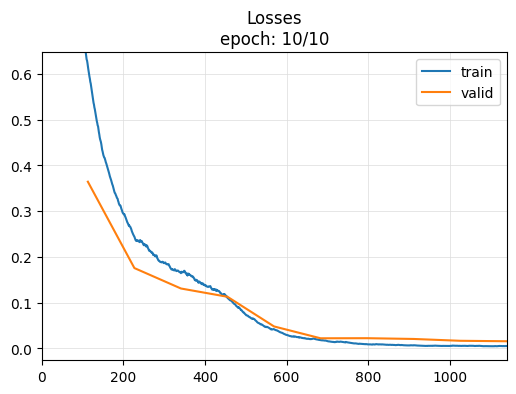

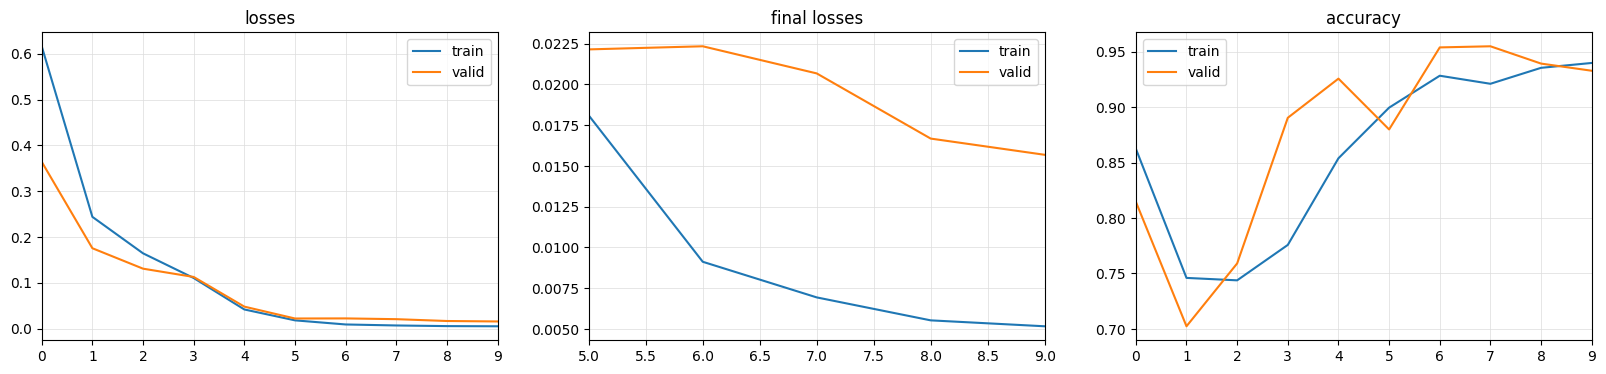

In [39]:
clf.fit_one_cycle(10, 1e-5)

In [47]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds = probas.argmax(dim=-1)

print(classification_report(target, preds, digits=4))

print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     1.0000    0.9243    0.9607      6366
           1     0.6717    1.0000    0.8036       986

    accuracy                         0.9344      7352
   macro avg     0.8358    0.9621    0.8821      7352
weighted avg     0.9560    0.9344    0.9396      7352

[[5884  482]
 [   0  986]]


In [ ]:
# Test metrics 
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds = probas.argmax(dim=-1)

print(classification_report(target, preds, digits=4))

print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     0.9970    0.9244    0.9593      2527
           1     0.6838    0.9833    0.8066       420

    accuracy                         0.9328      2947
   macro avg     0.8404    0.9539    0.8830      2947
weighted avg     0.9524    0.9328    0.9376      2947

[[2336  191]
 [   7  413]]


## InceptionTime with PU loss

In [49]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped

criterion = PULossWrapped(prior=positive_prior, nnPU=True)

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph())


epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.301987,0.862939,0.177861,0.854089,00:09
1,0.085446,0.907072,0.960082,0.147608,00:09
2,0.059250,0.917626,0.103860,0.945368,00:09
3,0.052273,0.921190,0.098904,0.954191,00:09
4,0.053279,0.915296,0.137900,0.901934,00:09
5,0.044169,0.956277,0.094325,0.964710,00:09
6,0.049276,0.945587,0.094902,0.960299,00:09
7,0.042229,0.948876,0.095996,0.971836,00:09
8,0.036453,0.958882,0.106654,0.957923,00:09
9,0.035168,0.957511,0.104768,0.964031,00:09


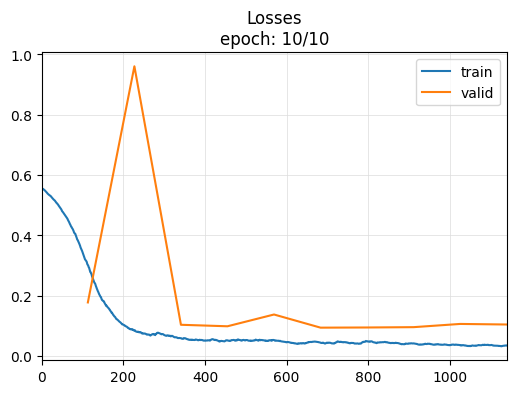

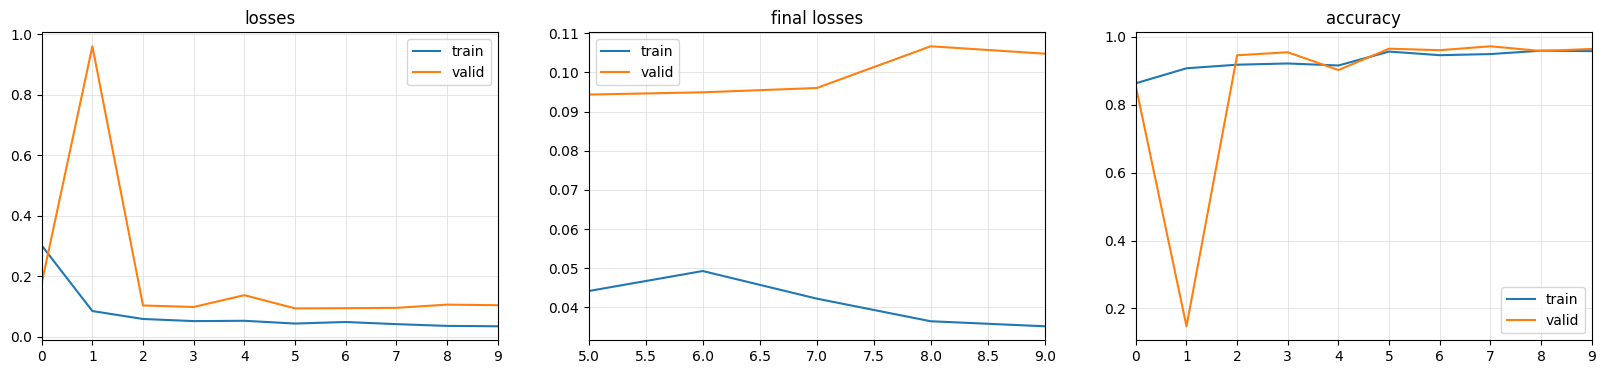

In [50]:
clf.fit_one_cycle(10, 1e-4)

In [51]:
clf.save("inctimennPU")

Path('models/inctimennPU.pth')

In [52]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape


(10299, 1, 561)

In [54]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds = probas.argmax(dim=-1)
print(classification_report(target, preds, digits=4))
print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     1.0000    0.9582    0.9787      6366
           1     0.7875    1.0000    0.8811       986

    accuracy                         0.9638      7352
   macro avg     0.8938    0.9791    0.9299      7352
weighted avg     0.9715    0.9638    0.9656      7352

[[6100  266]
 [   0  986]]


In [55]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds = probas.argmax(dim=-1)
print(classification_report(target, preds, digits=4))
print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     0.9903    0.9676    0.9788      2527
           1     0.8285    0.9429    0.8820       420

    accuracy                         0.9640      2947
   macro avg     0.9094    0.9552    0.9304      2947
weighted avg     0.9672    0.9640    0.9650      2947

[[2445   82]
 [  24  396]]


### uPU loss

In [56]:
criterion = PULossWrapped(prior=positive_prior, nnPU=False)

X_all = np.concatenate([X_train_np, X_test_np]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_np))),
          list(range(len(y_train_np), len(y_all))))

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf1 = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms, loss_func=criterion,
                   metrics=accuracy, cbs=ShowGraph())

In [58]:
clf1.load("clf_uPU")

epoch,train_loss,valid_loss,accuracy,time
0,0.353289,0.165575,0.858161,00:09
1,-0.492700,-0.649374,0.930777,00:09
2,-1.249743,-0.936388,0.951137,00:09
3,-1.910943,-1.751479,0.928062,00:09
4,-2.485722,-1.797891,0.963692,00:09
5,-2.882133,-1.737275,0.979640,00:09
6,-3.269513,-2.061474,0.975908,00:09
7,-3.448505,-2.489884,0.898202,00:09
8,-3.642734,-2.554059,0.967425,00:09
9,-3.625691,-2.324062,0.973872,00:09


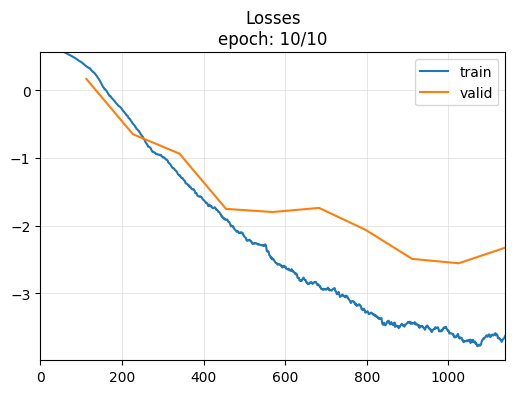

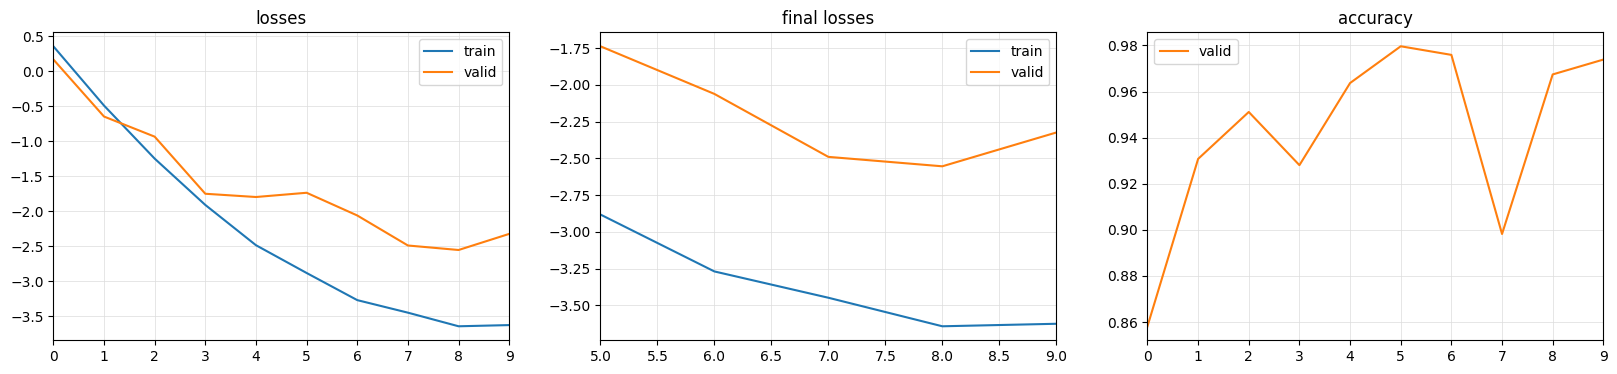

In [142]:
clf1.fit_one_cycle(10, 1e-4)

In [59]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(10299, 1, 561)

In [60]:
# Train metrics
probas, target = clf1.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds = probas.argmax(dim=-1)

print(classification_report(target, preds, digits=4))

print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     0.9997    0.9932    0.9965      6366
           1     0.9581    0.9980    0.9776       986

    accuracy                         0.9939      7352
   macro avg     0.9789    0.9956    0.9870      7352
weighted avg     0.9941    0.9939    0.9939      7352

[[6323   43]
 [   2  984]]


In [61]:
# Test metrics
probas, target = clf1.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds = probas.argmax(dim=-1)

print(classification_report(target, preds, digits=4))

print(confusion_matrix(target, preds))

              precision    recall  f1-score   support

           0     0.9936    0.9759    0.9846      2527
           1     0.8688    0.9619    0.9130       420

    accuracy                         0.9739      2947
   macro avg     0.9312    0.9689    0.9488      2947
weighted avg     0.9758    0.9739    0.9744      2947

[[2466   61]
 [  16  404]]


In [145]:
clf1.save("clf_uPU")

Path('models/clf_uPU.pth')